In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import pandas as pd
import tensorflow as tf

# Import our input dataset
charity_df = pd.read_csv('charity_data.csv')
charity_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
#Drop rows who are non-active
#charity_df[charity_df['STATUS'] != 1]
charity_df.drop(charity_df[charity_df['STATUS']!= 1].index, inplace=True)

In [3]:
#Drop rows who are not successful
#charity_df[charity_df['STATUS'] != 1]
charity_df.drop(charity_df[charity_df['IS_SUCCESSFUL']!= 1].index, inplace=True)

In [4]:
#What variable(s) are neither and should be removed from the input data?
#What variable(s) are considered to be the features for your model?
#Drop EIN, Name, Special Consideration, Status columns
charity_df.drop(['EIN','NAME','SPECIAL_CONSIDERATIONS','STATUS'],axis=1,inplace=True)
charity_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,0,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1-9999,108590,1
3,T3,CompanySponsored,C2000,Preservation,Trust,10000-24999,6692,1
4,T3,Independent,C1000,Heathcare,Trust,100000-499999,142590,1
5,T3,Independent,C1200,Preservation,Trust,0,5000,1


In [5]:
#Using the methods described in this module, preprocess all numerical and categorical variables
# Generate our categorical variable list
charity_cat = charity_df.dtypes[charity_df.dtypes == "object"].index.tolist()
charity_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT']

In [6]:
# Check the number of unique values in each column
charity_df[charity_cat].nunique()

APPLICATION_TYPE    17
AFFILIATION          6
CLASSIFICATION      63
USE_CASE             5
ORGANIZATION         4
INCOME_AMT           9
dtype: int64

In [7]:
# Check the unique value counts to see if binning is required
app_type_counts = charity_df.APPLICATION_TYPE.value_counts()
app_type_counts

T3     14385
T5       900
T6       900
T4       471
T10      464
T7       410
T8       311
T19      201
T9       112
T13       61
T12       24
T2         9
T14        3
T29        2
T25        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

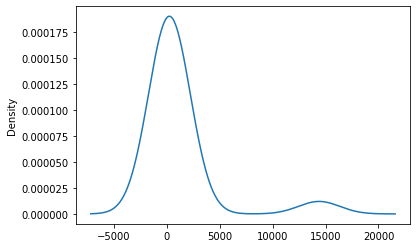

In [8]:
# Visualize the value counts
app_type_counts.plot.density()

In [9]:
# Determine which values to replace
replace_app_type = list(app_type_counts[app_type_counts < 500].index)

# Replace in DataFrame
for app_type in replace_app_type:
    charity_df.APPLICATION_TYPE = charity_df.APPLICATION_TYPE.replace(app_type,"Other")


# Check to make sure binning was successful
charity_df.APPLICATION_TYPE.value_counts()

T3       14385
Other     2073
T6         900
T5         900
Name: APPLICATION_TYPE, dtype: int64

In [10]:
#Encode categorical variables using one-hot encoding.
# Create the OneHotEncoder instance
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_app = pd.DataFrame(enc.fit_transform(charity_df.APPLICATION_TYPE.values.reshape(-1,1)))

# Rename encoded columns
encode_app.columns = enc.get_feature_names(['APPLICATION_TYPE'])
encode_app.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T3,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [11]:
# Merge the DataFrames together and drop the APPLICATION_TYPE column
charity_app_df = charity_df.merge(encode_app,left_index=True,right_index=True).drop("APPLICATION_TYPE",1)

In [12]:
charity_app_df.head()

,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T3,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6
0,Independent,C1000,ProductDev,Association,0,5000,1,1.0,0.0,0.0,0.0
1,Independent,C2000,Preservation,Co-operative,1-9999,108590,1,0.0,1.0,0.0,0.0
3,CompanySponsored,C2000,Preservation,Trust,10000-24999,6692,1,0.0,1.0,0.0,0.0
4,Independent,C1000,Heathcare,Trust,100000-499999,142590,1,0.0,1.0,0.0,0.0
5,Independent,C1200,Preservation,Trust,0,5000,1,0.0,1.0,0.0,0.0


In [13]:
charity_app_cat = charity_app_df.dtypes[charity_app_df.dtypes == "object"].index.tolist()
charity_app_cat

['AFFILIATION', 'CLASSIFICATION', 'USE_CASE', 'ORGANIZATION', 'INCOME_AMT']

In [14]:
# Check the number of unique values in each column
charity_app_df[charity_app_cat].nunique()

AFFILIATION        6
CLASSIFICATION    49
USE_CASE           5
ORGANIZATION       4
INCOME_AMT         9
dtype: int64

In [15]:
# Check the unique value counts to see if binning is required
class_count = charity_app_df.CLASSIFICATION.value_counts()
class_count

C1000    5656
C2000    1748
C1200    1250
C7000     406
C3000     307
C2100     279
C4000     105
C1700     102
C2700      57
C7100      47
C1270      43
C2800      23
C1240      21
C1230      19
C7200      17
C1280      15
C7120      13
C1400      12
C8000       9
C1800       7
C1235       6
C7210       6
C6000       6
C1600       4
C1300       4
C2300       4
C1237       4
C1500       4
C4100       3
C1238       3
C1720       3
C1278       3
C1250       2
C1260       2
C1257       1
C2561       1
C1728       1
C1570       1
C8200       1
C1283       1
C4120       1
C2170       1
C5000       1
C1245       1
C3700       1
C2500       1
C8210       1
C2400       1
C4500       1
Name: CLASSIFICATION, dtype: int64

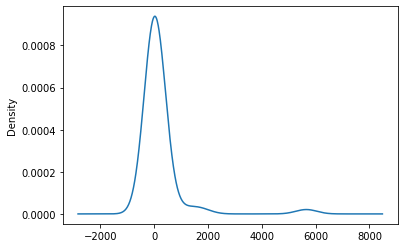

In [16]:
# Visualize the value counts
class_count.plot.density()

In [17]:
# Determine which values to replace
replace_class = list(class_count[class_count < 100].index)

# Replace in DataFrame
for class_type in replace_class:
    charity_app_df.CLASSIFICATION = charity_app_df.CLASSIFICATION.replace(class_type,"Other")


# Check to make sure binning was successful
charity_app_df.CLASSIFICATION.value_counts()

C1000    5656
C2000    1748
C1200    1250
C7000     406
Other     352
C3000     307
C2100     279
C4000     105
C1700     102
Name: CLASSIFICATION, dtype: int64

In [18]:
#Encode categorical variables using one-hot encoding.
# Create the OneHotEncoder instance
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_class = pd.DataFrame(enc.fit_transform(charity_app_df.CLASSIFICATION.values.reshape(-1,1)))

# Rename encoded columns
encode_class.columns = enc.get_feature_names(['CLASSIFICATION'])
encode_class.head()

,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C1700,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_C4000,CLASSIFICATION_C7000,CLASSIFICATION_Other
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Merge the DataFrames together and drop the CLASSIFICATION column
charity_class_df = charity_app_df.merge(encode_class,left_index=True,right_index=True).drop("CLASSIFICATION",1)
charity_class_df.head()

,AFFILIATION,USE_CASE,ORGANIZATION,INCOME_AMT,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T3,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C1700,CLASSIFICATION_C2000,CLASSIFICATION_C2100,CLASSIFICATION_C3000,CLASSIFICATION_C4000,CLASSIFICATION_C7000,CLASSIFICATION_Other
0,Independent,ProductDev,Association,0,5000,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Independent,Preservation,Co-operative,1-9999,108590,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,CompanySponsored,Preservation,Trust,10000-24999,6692,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Independent,Heathcare,Trust,100000-499999,142590,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Independent,Preservation,Trust,0,5000,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
#Categorical column
categorical_column = charity_class_df.dtypes[charity_class_df.dtypes == "object"].index.tolist()
categorical_column

['AFFILIATION', 'USE_CASE', 'ORGANIZATION', 'INCOME_AMT']

In [21]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_categorical_df = pd.DataFrame(enc.fit_transform(charity_class_df[categorical_column]))

# Add the encoded variable names to the DataFrame
encode_categorical_df.columns = enc.get_feature_names(categorical_column)
encode_categorical_df.head()

,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Regional,USE_CASE_CommunityServ,USE_CASE_Heathcare,USE_CASE_Other,USE_CASE_Preservation,USE_CASE_ProductDev,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Merge one-hot encoded features and drop the originals
charity_class_df = charity_class_df.merge(encode_categorical_df,left_index=True, right_index=True)
charity_class_df = charity_class_df.drop(categorical_column,1)
charity_class_df.head()

,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T3,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,CLASSIFICATION_C1000,CLASSIFICATION_C1200,CLASSIFICATION_C1700,CLASSIFICATION_C2000,...,ORGANIZATION_Trust,INCOME_AMT_0,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M
0,5000,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,108590,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6692,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,142590,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5000,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#Standardize numerical variables using Scikit-Learn’s StandardScaler class.
# Remove loan status target from features data
y = charity_class_df.IS_SUCCESSFUL.values
X = charity_class_df.drop(columns=["IS_SUCCESSFUL"]).values

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [25]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  24
hidden_nodes_layer2 = 12
hidden_nodes_layer3 = 8

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
#nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
# Train the model 
fit_model = nn.fit(X_train_scaled, y_train, epochs=50) 
# Evaluate the model using the test data 
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Train on 2249 samples
Epoch 1/50
2249/2249 [==============================] - 1s 362us/sample - loss: 0.1016 - accuracy: 1.0000
Epoch 2/50
2249/2249 [==============================] - 0s 45us/sample - loss: 0.0101 - accuracy: 1.0000
Epoch 3/50
2249/2249 [==============================] - 0s 49us/sample - loss: 0.0030 - accuracy: 1.0000
Epoch 4/50
2249/2249 [==============================] - 0s 50us/sample - loss: 0.0015 - accuracy: 1.0000
Epoch 5/50
2249/2249 [==============================] - 0s 46us/sample - loss: 9.3525e-04 - accuracy: 1.0000
Epoch 6/50
2249/2249 [==============================] - 0s 45us/sample - loss: 6.4043e-04 - accuracy: 1.0000
Epoch 7/50
2249/2249 [==============================] - 0s 45us/sample - loss: 4.6657e-04 - accuracy: 1.0000
Epoch 8/50
2249/2249 [==============================] - 0s 44us/sample - loss: 3.5636e-04 - accuracy: 1.0000
Epoch 9/50
2249/2249 [==============================] - 0s 46us/sample - loss: 2.8141e-04 - accuracy: 1.0000
Epoch 10/50
